1. Read all the TSV files into an array, write a function to extract the title and authors data
2. Go through each TSV and use title and authors to search the OCLC for OWI number
3. Go through each OWI and get:
    3.1 Earliest year published
    3.2 Holdings
    3.3 For OWI with the most holdings: VIAF -> Genders
    3.5 For each OWI where "book" in .get("format")
    Make Genders -> DDC dict, add to it manually
4. Make a dict of TITLE/AUTHOR STRING -> OWI, YEAR_PUBLISHED, GENDER(S), TOP_DDC, FAST_LIST?

In [61]:
import csv, os
from datetime import datetime
#import datetime
f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
data_i = 2 #How far into the tsv file the data shows up...
fields = ['rank','title+author','rank_last_week','weeks_on_list']
stop_words_authors = ["Others"]

# Read the Data In

In [62]:
def empty(row):
    if row[0]=="":
        return True
    return False 

def extract_date(datestr):
    try:
        date = datetime.strptime(datestr[0],'%B %d, %Y')
    except ValueError:
        date = datetime.strptime(datestr[0],'%B %d,%Y')
    return date

def extract_date_filen(datestr):
    f_from_path = datestr.split("/")[2]
    wo_extension = f_from_path.split(".")[0]
    date = datetime.strptime(wo_extension,'%Y-%m-%d')
    return date

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def header(row):
    if is_number(row[0]):
        return False
    else:
        return True
    
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        previous_previous_row = ""
        previous_row = ""
        for row in reader:
            if (not empty(row)):
                if (header(row)) & (i>data_i):
                    return arr
                if i==0:
                    date_field = [row[1]]
                    if row[1] == "":
                        date_field = [row[2]]
                    try:
                        date = extract_date(date_field)
                    except:
                        date = extract_date_filen(name)
                if (i > data_i):
                    if row[1] == "":
                        row[1] = previous_row[1]
                    arr.append([date]+row)
                i = i+1
            previous_row = row
        return arr
    
def read_folder(folderpath):
    arr = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(folderpath+f)
        arr = arr+commasv
    return arr

eighty_path = "tsvs/1980s/"
eighties = read_folder(eighty_path)
seventies_path = "tsvs/1970s/"
seventies = read_folder(seventies_path)
sixties_path = "tsvs/1960s/"
sixties = read_folder(sixties_path)
fifties_path = "tsvs/1950s/"
fifties = read_folder(fifties_path)

nineties = read_folder("tsvs/1990s/")
thousands = read_folder("tsvs/2000s/")

for x in nineties[0:10]:
    print x
    
    
to_process = fifties + sixties + seventies + eighties + nineties + thousands
print len(to_process)

[datetime.datetime(1996, 5, 19, 0, 0), '2', 'THE TENTH INSIGHT, by James Redfield. (Warner, $19.95.) A journey through', '3', '2']
[datetime.datetime(1996, 5, 19, 0, 0), '3', 'MOONLIGHT BECOMES YOU, by Mary Higgins Clark. (Simon & Schuster, $24.)', '1', '5']
[datetime.datetime(1996, 5, 19, 0, 0), '4', 'MALICE, by Danielle Steel. (Delacorte, $24.95.) A woman struggles to overcome', '2', '4']
[datetime.datetime(1996, 5, 19, 0, 0), '5', 'THE CELESTINE PROPHECY, by James Redfield. (Warner, $17.95.) An ancient', '5', '116']
[datetime.datetime(1996, 5, 19, 0, 0), '6', 'PRIMARY COLORS, by Anonymous. (Random House, $24.) The progress of a', '4', '15']
[datetime.datetime(1996, 5, 19, 0, 0), '7', 'TIMEPIECE, by Richard Paul Evans. (Simon & Schuster, $18.) By sharing grief', '7', '3']
[datetime.datetime(1996, 5, 19, 0, 0), '8', 'NEANDERTHAL, by John Darnton. (Random House, $24.) The discovery in', '12', '3']
[datetime.datetime(1996, 5, 19, 0, 0), '9', 'THE HORSE WHISPERER, by Nicholas Evans. (Del

# Get Title and Author

In [2]:
import pickle

def write_obj(obj,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b

from_pdf_dict = load_obj("from_pdf_manual.pickle")

In [65]:
skip_these = set()

In [66]:
auth_i = 4

# strip trailing char if '.' or ' '
def strip_trailing_punct(a):
    last_char = a[len(a)-1]
    if (last_char != '.') & (last_char != ' '):
        return a
    b = a[:len(a)-1] 
    return strip_trailing_punct(b)


def parse_author_phrase(a_ph):
    authors = []
    end = len(a_ph)
    parens = a_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = a_ph[auth_i:end]
    if " and " in auth_ph:
        author_arr = auth_ph.split(" and ")
        for author in author_arr:
            author = strip_trailing_punct(author)
            if author not in stop_words_authors:
                authors.append(author)
    else:
        author = auth_ph
        author = strip_trailing_punct(author)
        authors.append(author)
    return authors

def title_author_pair(data_str):
    if data_str in from_pdf_dict:
        return from_pdf_dict[data_str]
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    i=0
    t=True
    for phrase in split_str:    
        if i == 0:
            title = phrase
        else:
            if phrase.isupper() & t:
                title = title + ", "+phrase
            else:
                t = False
                auth_ph = auth_ph+phrase
        i = i+1
    try:
        authors = parse_author_phrase(auth_ph)
        if authors == []:
            authors = [data_str]
    except:
        skip_these.add(data_str)
        authors = [data_str]
    return (title,authors)

ta = set()
i = 0
for x in to_process:
    title = title_author_pair(x[2])
    if title[0] == "":
        print i
        print x
        i = i+1
        ta.add(str(title))
print "len ta = "+str(len(ta))
print len(thousands)


i =0 
for x in ta:
    print x
    i = i+1
    if i>10:
        break


len ta = 0
11499


In [6]:
print title_author_pair("THE LAST HURRAH, by Margaret Attenbourough. (gestated in utero.)")

('THE LAST HURRAH', ['Margaret Attenbourough'])


In [7]:
for x in from_pdf_dict:
    print x + str(from_pdf_dict[x])

HIDDEN PASSIONS: Secrets From the Diaries of Tabitha Lenox.('HIDDEN PASSIONS: SECRETS FROM THE DIARIES OF TABITHA LENOX', ['Alice Alfonsi'])
MAGIC KINGDOM FOR SALE: Sold! by Terry Brooks. (Del Rey/Ballantine,('MAGIC KINGDOM FOR SALE: SOLD!', ['Terry Brooks'])
ALL THE LIGHT WE CANNOT SEE. by Anthony Doerr. (Scribner.) The lives of a('ALL THE LIGHT WE CANNOT SEE', ['Anthony Doerr'])
WHERE IS JOE MERCHANT? by Jimmy Buffett. (Harcourt Brace Jovanovich,('WHERE IS JOE MERCHANT?', ['Jimmy Buffett'])
WHAT'S HEAVEN? by Maria Shriver. Illustrated by Sandra Speidel. (Golden("WHAT'S HEAVEN?", ['Maria Shriver', 'Sandra Speidel'])
DISNEY'S BEAUTY AND THE BEAST. (Gallery Books/Penguin USA, $6.98.) A("DISNEY'S BEAUTY AND THE BEAST", ['Disney'])
AI! PEDRITO! by L. Ron Hubbard and Kevin J. Anderson. (Bridge Publications,('AI! PEDRITO!', ['L. Ron Hubbard', 'Kevin J. Anderson'])
THE COLLECTED STORIES OF EUDORA WELTY. (Harcourt Brace Jovanovich,('THE COLLECTED STORIES OF EUDORA WELTY', ['Eudora Welty'])
HI

# To OCLC


In [3]:
import xml.etree.ElementTree
import json
import urllib2
import re

ta_to_data_dict = load_obj("free_range.pickle") 
oclc_base = "http://classify.oclc.org/classify2/Classify?"
alph = re.compile('[^a-zA-Z]')
suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

In [69]:
def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False
    
def strip_punct(text):
    return alph.sub('', text)

def norm_text(text):
    return strip_punct(text).lower()

def url_to_data(url,f):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    if(f=="xml"):
        data = xml.etree.ElementTree.parse(res).getroot()
    if(f=="json"):
        data = json.load(res)
    return data

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                if ch == "'":
#                    print "adding char encoding"
                    return_string = return_string+"%27"
                else:
                    return_string = return_string+ch
        last_ch = ch
    return return_string

def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

In [6]:
from lxml import html
from bs4 import BeautifulSoup
import requests

viaf_base = "http://www.viaf.org/viaf/"
    
def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    if personal is None:
        return ""
    h4s = personal.find('h4')
    if (h4s is None) or (len(h4s)<5):
        return ""
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        i = i+1
    return str(mt[4])

In [70]:
import fuzzywuzzy
from fuzzywuzzy import fuzz
fuzz_thresh = 80

def fuzzy_substr(s1,s2):
    teststr = norm_text(s1)
    checkstr = norm_text(s2)
    ratio = fuzz.partial_ratio(teststr,checkstr)
#    print teststr
#    print checkstr
#    print ratio
    if ratio >= fuzz_thresh:
        return True
    else:
        return False
    
    
def alt_is_book(w,t,a):
    if "book" in norm_text(w.get("format")):
        check_title = w.get("title")
        if (check_title is not None) and (fuzzy_substr(t,check_title)):
            for auth in a:
                check_author = w.get("author")
                if (check_author is not None) and (fuzzy_substr(last_name(auth),check_author)):
                    if fuzzy_substr(first_name(auth),check_author):
                        return True
    return False

def alt_get_viaf(author, viaf_dict_arr):
    l = last_name(author)
    f = first_name(author)
    target = ""
    for v in viaf_dict_arr:
        if fuzzy_substr(l,v['name']):
            target = v['viaf']
            if fuzzy_substr(f,v['name']):
                return v['viaf']
    return target


def is_book(w,t,a):
#    print w
#    print t
#    print a
    if "book" in norm_text(w.get("format")):
#        print norm_text(t)
#        print norm_text(w.get("title"))
        if norm_text(t) in norm_text(w.get("title")):
#            print "inside if"
            for auth in a:
#                print last_name(auth)
#                print first_name(auth)
                if norm_text(last_name(auth)) in norm_text(w.get("author")):
                    if norm_text(first_name(auth))in norm_text(w.get("author")):
                        return True
    return False

def find_all_works(xml,title,authors):
    works = xml.find('{http://classify.oclc.org}works')
    if works is None:
        works = []
        works.append(xml.find('{http://classify.oclc.org}work'))
#        print works
        if (works is None) or (works == []) or (works[0] is None):
            return []
    books = []
    for w in works:
        holdings = w.get("holdings")
        if (int(holdings) > 10) & (alt_is_book(w,title,authors)):
            owi = w.get("owi")
            try:
                lyr = w.get("lyr")
            except:
                lyr = ""
            books.append({"owi":owi,"holdings":holdings,"lyr":lyr})
    #print "NUM BOOKS: "+str(len(books))
    return books

def new_work(w, entries):
    if int(w['holdings']) < 50:
        return False
    for e in entries:
        if w['owi'] == e["owi"]:
             return False
    return True

def get_oclc_entries(title,authors):
    url = oclc_base +"title="+convert_to_search(title)
    #i = 0
    entries = []
    for a in authors:
        auth_url = url +"&author=" + last_name(a)
#        print auth_url
        xml = url_to_data(auth_url,"xml")
#        print xml
#        try:
        works = find_all_works(xml,title,authors)
#        except:
#            return []
        if works is None:
            return []
        if entries == []:
            entries = works
        else:
            for w in works:
                if new_work(w,entries):
                    entries.append(w)
        #i = i+1
    return entries
    
print get_oclc_entries('THE CITY OF MIRRORS', ['Justin Cronin']) 
#print get_oclc_entries('SEVEN DAYS IN MAY', ['Fletcher Knebel']) 

def max_holding(oarr):
    target = oarr[0]
    for o in oarr[1:]:
        if int(o['holdings'])>int(target['holdings']):
            target = o
    return target

def get_authors(xml):
    authors = xml.find('{http://classify.oclc.org}authors')
    target = []
    for a in authors:
        text = a.text
        v = a.get('viaf')
        target.append({'name':text, 'viaf':v})
    return target

def get_fast(xml):
    recs = xml.find('{http://classify.oclc.org}recommendations')
    target = []
    if recs is not None:
        fast = recs.find('{http://classify.oclc.org}fast')
        if fast is not None:
            headings = fast.find('{http://classify.oclc.org}headings')
            for h in headings:
                if int(h.get('heldby'))>10:
                    target.append(h.text)
    return target

def lookup_oclc(owi):
    url = oclc_base+"owi="+owi
    xml = url_to_data(url,"xml")
    try:
        v = get_authors(xml)
    except:
        print url
        print xml
        response_code = xml.find('{http://classify.oclc.org}response').get("code")
        if response_code == '102':
            print '102!'
        v = [{'name':'','viaf':''}]
    fast = get_fast(xml)
    target = {'authors':v,'fast':fast}
    return target

test_author_dict = [{'viaf': '22619695', 'name': 'Bailey, Charles Waldo, 1929-2012 [Author]'}, {'viaf': '19720195', 'name': 'Knebel, Fletcher'}]

def get_genders(authors, viaf_dict):
    target = []
    for a in authors:
        v = alt_get_viaf(a,viaf_dict)
        gender = get_gender_scrape(v)
        target.append({"name":a,"viaf":v,"gender":gender})
    return target
    
def get_viaf(author, viaf_dict_arr):
    l = norm_text(last_name(author))
    f = norm_text(first_name(author))
    target = ""
    for v in viaf_dict_arr:
        if l in norm_text(v['name']):
            target = v['viaf']
            if f in norm_text(v['name']):
                return v['viaf']
    return target

print(get_genders(["Fletcher Knebel","Charles W. Bailey II"],test_author_dict))


[{'holdings': '2020', 'owi': '2625491914', 'lyr': '2015'}, {'holdings': '814', 'owi': '2409782529', 'lyr': '2014'}]
[{'gender': 'Male', 'viaf': '19720195', 'name': 'Fletcher Knebel'}, {'gender': 'Male', 'viaf': '22619695', 'name': 'Charles W. Bailey II'}]


In [14]:
test_tas = [("LADY CHATTERLY'S LOVER",["D.H. Lawrence"]),
            ("THE PLYMOUTH ADVENTURE",["Ernest Gebler"]),
            ("SLEEP TILL NOON",["Max Shulman"]),
            ("BARABBAS",["Par Lagerkvist"]),
            ("YOU SHALL KNOW THEM",["Rita Vercors"])]

for x in test_tas:
    print process_input_data(x)

http://classify.oclc.org/classify2/Classify?title=LADY+CHATTERLY'S+LOVER&author=Lawrence
NUM BOOKS: 3
False
False
{'genders': [{'gender': 'Male', 'viaf': '95150359', 'name': 'D.H. Lawrence'}], 'year_pub': '1950', 'owi': '473258347', 'fast_subjects': set(['Married women', 'Gamekeepers', 'Aristocracy (Social class)', 'Great Britain', 'Adultery', 'English fiction', 'England', 'Runaway wives'])}
http://classify.oclc.org/classify2/Classify?title=THE+PLYMOUTH+ADVENTURE&author=Gebler
NUM BOOKS: 2
False
False
{'genders': [{'gender': 'Male', 'viaf': '79470343', 'name': 'Ernest Gebler'}], 'year_pub': '1940', 'owi': '1472514', 'fast_subjects': set(['Mayflower (Ship)', 'Massachusetts'])}
http://classify.oclc.org/classify2/Classify?title=SLEEP+TILL+NOON&author=Shulman
False
True
{'genders': [], 'year_pub': [], 'owi': '', 'fast_subjects': set([])}
http://classify.oclc.org/classify2/Classify?title=BARABBAS&author=Lagerkvist
NUM BOOKS: 2
False
False
{'genders': [{'gender': 'Male', 'viaf': '64007846', 

In [13]:
skipped_ta = []
print len(ta_to_data_dict)

5325


In [68]:
import sys

def process_input_data(ta):       
    # if str(ta) not in ta_to_oclc_dict: CHECK FOR THIS OUTSIDE THE FN
    title = ta[0]
    author = ta[1]
    oclc = get_oclc_entries(title,author)
#    print oclc is None
#    print len(oclc)<1
    if (oclc is None) or (len(oclc)<1):
        skipped_ta.append(ta)
        owi = ""
        holdings = []
        year_pub = []
        fast_subjects = set()
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects.update(other_data['fast'])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = get_genders(author, primary_data['authors'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

## need to add the original data (date, year, rankings) if this is the ultimate output
def process_raw_list(input_ls):
    #print "INPUT! "+ str(input_ls)
    target = []
    i = 0
    for row in input_ls:
        date = row[0]
        year = date.year
        if row[2] != "UNKNOWN":
            ta = title_author_pair(row[2])
            target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year}
            string_ta = str(ta)
            if string_ta in ta_to_data_dict:
                target_row.update(ta_to_data_dict[string_ta])
            else:
                try:
                    p = process_input_data(ta)
                    target_row.update(p)
                    if ((p["owi"] != "") & (len(p['genders'])>0) & (len(p['fast_subjects'])>0)):
                        ta_to_data_dict[string_ta] = p
                        j = len(ta_to_data_dict)
                        if ((j%25 == 0) or (i == (len(input_ls)-1))):
                            print j
                            write_obj(ta_to_data_dict,"free_range.pickle")
                except:
                    print "Unexpected error:", sys.exc_info()[0]
                    return target
        target.append(target_row)
        i = i+1
    return target



In [12]:
print process_input_data(("ARMAGEDDON",["Leon Uris"]))

{'genders': [{'gender': 'Male', 'viaf': '66474442', 'name': 'Leon Uris'}], 'year_pub': '1961', 'owi': '47905910', 'fast_subjects': set(['Germany', 'Blockade of Berlin (Germany : 1948-1949)', 'Holocaust, Jewish--(1939-1945)', 'Cold War (1945-1989)', 'Germany--Berlin'])}


In [71]:
processed = process_raw_list(to_process)
write_obj(processed,"processed_arr.pickle")
#processed = load_obj("processed_arr.pickle")
print processed[0]
print len(processed)


5425
{'owi': '104466836', 'title': 'THE SILVER CHALICE', 'year': 1953, 'fast_subjects': set(['Historical fiction', 'Jesus Christ', 'Christian fiction', 'History of Biblical events', 'Grail', 'Bible.--New Testament', 'Last Supper']), 'year_pub': '1926', 'authors': ['Thomas B. Costain'], 'date': datetime.datetime(1953, 4, 19, 0, 0), 'genders': [{'gender': 'Male', 'viaf': '97749233', 'name': 'Thomas B. Costain'}]}
44331


In [ ]:
print len(skipped_ta)



def print_head(sset,limit):
    i = 0
    for s in sset:
        if i>limit:
            return
        print s
        i = i+1

print_head(skipped_ta,50)

In [99]:
import matplotlib
%matplotlib inline

genre_terms = ["fiction","stories","tales","literature","opera"]
genre_dict = {"romance":{"keys":["romance","erotic"],"stops":["language"]}, #took out 'domestic'
              "domestic":{"keys":["domestic"]},
              "suspense":{"keys":["suspense"]},
              "legal":{"keys":["legal"]},
              "horror":{"keys":["horror","paranormal"]},
              "mystery":{"keys":["mystery","detective","crime"]},
              "spy_and_politics":{"keys":["spy ","politic"]},
              "fsf":{"keys":["fantasy","science fiction", "space","cyberpunk","steampunk"]},
              "adventure":{"keys":["adventure","western","sea "]},
              "ya":{"keys":["young adult"]},
              "war":{"keys":["war "]},
              "religious":{"keys":["religious","christian"],"stop":["aspects"]},
              "historical":{"keys":["historical"]} ## <-- I think this one might not be a well-supported
                                                   ## category in the DB
            }

def genre_candidate(fast_term):
    for term in genre_terms:
        if term in norm_text(fast_term):
            return True
    return False

def is_genre(fast_term,genre_str):
    terms = genre_dict[genre_str]['keys']
    if 'stops' in genre_dict[genre_str]:
        stops=genre_dict[genre_str]['stops']
    else:
        stops = []
    target = False
    for term in terms:
        if term in fast_term.lower():
            target = True
    for stop in stops:
        if stop in fast_term.lower():
            target = False
    return target

#def classify_genre(processed_row):
#    subjects = processed_row['fast_subjects']
def classify_genre(subjects):
    #print subjects
    target = {}
    for genre in genre_dict:
        target[genre]=0
    for subject in subjects:
        if genre_candidate(subject):
            for genre in genre_dict:
                if is_genre(subject,genre):
                    target[genre] = 1
    return target

def percent_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    for genre in genre_dict:
        counts_dict[genre] = float(counts_dict[genre])/float(len(cl_ls))
    return counts_dict  

def tally_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    return counts_dict  
    
def tally_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        i = 0          
        tallied = tally_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

def percent_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    
    ## change the binning from average to sum
    df = df.drop_duplicates(["title",group_val])
    
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        tallied = percent_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

In [19]:
import pandas
print pandas.__version__

terms = []
for x in processed:
    for y in x['fast_subjects']:
        if genre_candidate(y):
            terms.append(y)
    
term_series = pandas.Series(terms)
counts = term_series.value_counts()
print len(processed)
print(counts)

0.19.2
44331
English fiction                                     3621
Detective and mystery stories                       3361
American fiction                                    2837
Romance fiction                                     2170
Adventure stories                                   1978
Domestic fiction                                    1852
Fiction                                             1784
Spy stories                                         1400
Suspense fiction                                    1377
Historical fiction                                  1305
Psychological fiction                               1189
Science fiction                                      981
Legal stories                                        959
Horror tales                                         886
Fantasy fiction                                      845
Spanish fiction                                      715
Political fiction                                    684
War stories       

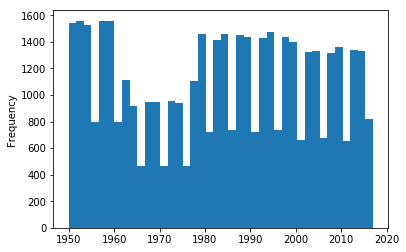

In [23]:
s = pandas.Series(pandas.DataFrame(processed)["year"])
s.plot(kind="hist",bins=40)

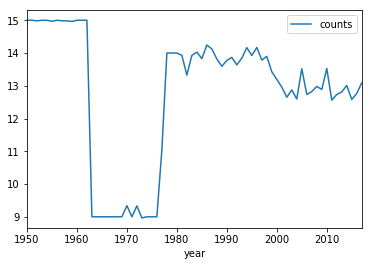

In [72]:
s = pandas.DataFrame(pandas.DataFrame(processed)[["year","date"]])
s['counts'] = s.groupby(['date']).transform('count')
s['counts'] = s['counts'].astype(int)
s_grouped = s.groupby("year")

fig_3 = s_grouped.mean().plot().get_figure()
fig_3.savefig("bestsellers_list_length.png")


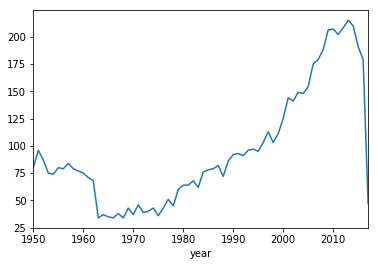

In [98]:
df = pandas.DataFrame(processed).groupby("year")
unique_counts = df.apply(unique_titles).apply(len)
fig = unique_counts.plot().get_figure()
fig.savefig("unique_titles_per_year2.png")

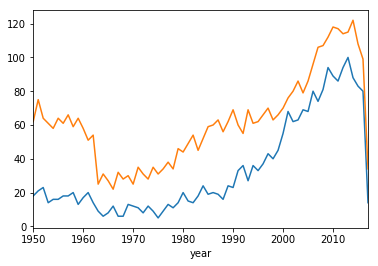

In [20]:
gendered = split_by_gender(processed)

genders = ["female","male"]

i = 0
for g in gendered:
    df = pandas.DataFrame(g).groupby("year")
    unique_counts = df.apply(unique_titles).apply(len)
    fig = unique_counts.plot().get_figure()
    fig.savefig("unique_titles_per_gender"+genders[i]+"2.png")
    i = i+1

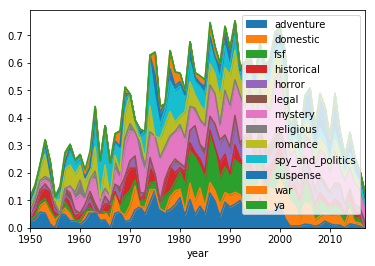

In [100]:
#tall_df = pandas.DataFrame(tally_genres_binned(processed,"year")).set_index("year")
#fig1 = tall_df.plot().get_figure()
#fig1.savefig("genre_tallies_year.png")

per_df = pandas.DataFrame(percent_genres_binned(processed,"year")).set_index("year")
fig = per_df.plot.area().get_figure()
fig.savefig("genre_percent_year3.png")

#tall_week_df = pandas.DataFrame(tally_genres_binned(processed,"date")).set_index("date")
#fig4 = tall_week_df.plot.area().get_figure()
#fig.savefig("by_week.png")

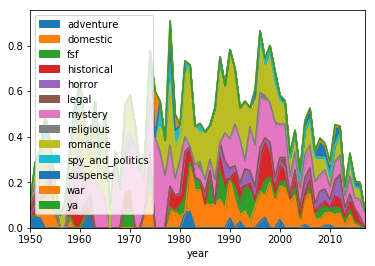

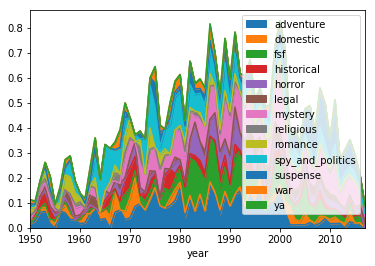

In [22]:
gendered = split_by_gender(processed)

genders = ["female","male"]

i = 0
for g in gendered:
    per_df = pandas.DataFrame(percent_genres_binned(g,"year")).set_index("year")
    fig = per_df.plot.area().get_figure()
    fig.savefig("genre_percent_year_"+genders[i]+"2.png")
    i = i+1

False
True
Female: 154
Male: 26
0.855555555556
Female: 1232
Male: 1864
0.397932816537
Female: 187
Male: 67
0.736220472441
Female: 35
Male: 1015
0.0333333333333
Female: 1931
Male: 2
0.998965338852


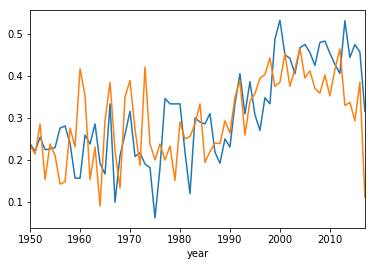

In [122]:
def is_any_genre(fast_ls):
    for x in fast_ls:
        for key in genre_dict:
#        key ="mystery"
            if is_genre(x,key):
                return True
    return False

df = pandas.DataFrame(processed)
df = df.drop_duplicates(["title","year"])
df["is_genre"] = df["fast_subjects"].apply(is_any_genre)
df["gender"] = df["genders"].apply(class_gender)

ndf = percent_women_binned(df,"year")
# df = df[df["year"].astype(int)>1990]

i = 0
grouped = df.groupby("is_genre")
for g in grouped:
    print g[0]
    p = percent_women_binned(g[1],"year")
    if i == 0:
        ax = pandas.DataFrame(p).set_index("year").plot(legend = False)
    else:
        pandas.DataFrame(p).set_index("year").plot(ax = ax,legend=False)
        fig = ax.get_figure()
        #fig.savefig("romance_v_not.png")
    i = i+1
    

grouped = df.groupby(["is_genre","gender"]).size()
grouped



i = 0
for x in grouped:
    if i%2 == 0:
        female = x
        print "Female: "+ str(female)
    else:
        male = x
        print "Male: "+ str(male)
        print float(female)/float(female+male)
    i = i+1



In [44]:
cleanup_dict = load_obj("cleanup.pickle")

for x in empties:
    ta = (x["title"],x["authors"])
    if "'" in ta[0]:
        if str(ta) not in cleanup_dict:
            proc_ta = process_input_data(ta)
            if proc_ta["owi"] != "":
                cleanup_dict[str(ta)] = proc_ta
        
print len(cleanup_dict)

adding char encoding
http://classify.oclc.org/classify2/Classify?title=HADRIAN%27S+MEMOIRS&author=Yourcenar
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+STORIES+OF+FRANK+O%27CONNER&author=O'Conner
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=JARRET%27S+JADE&author=Yerby
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+EXECUTIONER%27S+SONG&author=Mailler
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=RACHEL,++THE+RABBI%27S+WIFE&author=Tenenbaum
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+HANDMAID%27S+TALE&author=the
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+SPLENDID+OUTCAST:+Beryl+Markham%27s+African+Stories&author=Mary
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+CHILDREN%27S+BOOK+OF+VIRTUES&author=Illustrated
Fal

[1953 1953 1953 ..., 2004 2004 2004]
Total: 242
44331
{'owi': '', 'title': "LADY CHATTERLY'S LOVER", 'year': 1959, 'fast_subjects': set([]), 'year_pub': [], 'authors': ['D.H. Lawrence'], 'date': datetime.datetime(1959, 10, 11, 0, 0), 'genders': []}
{'owi': '', 'title': 'THE PLYMOUTH ADVENTURE', 'year': 1950, 'fast_subjects': set([]), 'year_pub': [], 'authors': ['Ernest Gebler'], 'date': datetime.datetime(1950, 6, 4, 0, 0), 'genders': []}
{'owi': '', 'title': 'SLEEP TILL NOON', 'year': 1950, 'fast_subjects': set([]), 'year_pub': [], 'authors': ['Max Shulman'], 'date': datetime.datetime(1950, 6, 4, 0, 0), 'genders': []}
{'owi': '', 'title': 'BARABBAS', 'year': 1952, 'fast_subjects': set([]), 'year_pub': [], 'authors': ['Par Lagerkvist'], 'date': datetime.datetime(1952, 2, 3, 0, 0), 'genders': []}
{'owi': '', 'title': 'RALLY ROUND THE FLAG BOYS!', 'year': 1958, 'fast_subjects': set([]), 'year_pub': [], 'authors': ['Max Schulman'], 'date': datetime.datetime(1958, 1, 5, 0, 0), 'genders': []

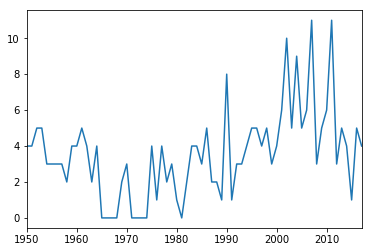

In [20]:
df = pandas.DataFrame(processed)

years = df["year"].values
print years

def init_year_dict(ls):
    df = pandas.DataFrame(ls)
    years = df["year"].values
    target = {}
    for y in years:
        target[y] = 0
    return target

def count_values(ls,column,to_count):
    target = init_year_dict(ls)
    i = 0
    if column == "genders":
        for item in ls:
            for nest_item in item[column]:
                if nest_item['gender'] == to_count:
#                    print x['authors']
                    year = item["year"]
                    target[year] = target[year]+1
                    i = i+1
    else:
        for item in ls:
            if len(item[column]) == 0:
                year = item["year"]
                target[year] = target[year]+1
                i = i+1
    print "Total: "+ str(i)
    return target

def construct_check(x_dict,field_ls):
    target = {}
    for field in field_ls:
        target[field] = x_dict[field]
    return target

def unique_entries(ls,field_ls):
    unique_fields = []
    target = []
    for x in ls:
        check_str = str(construct_check(x,field_ls))
        if check_str not in unique_fields:
            unique_fields.append(check_str)
            target.append(x)
    return target

unique_ta = []
unique_processed = unique_entries(processed,["title","authors"])
        
empties = count_values(unique_processed,"owi","")
#empties = count_values(unique_processed,"fast_subjects",[])
#empties = count_values(unique_processed,"genders","")
print len(processed)
s = pandas.Series(empties)
s.plot()
s



def get_empties(ls,field):
    i = 0
    target = []
    for x in ls:
        if len(x[field]) == 0:
            target.append(x)
            if i < 10:
                print x
    return target

empties = get_empties(unique_processed,"owi")

def fill_manual_dict(orig_ls,failed_field,target):
    target = []
    empties = get_empties(orig_ls,failed_field)
    for e in empties:
        print e
    return target

In [22]:
def csv_str(ls,delim):
    target = ""
    i = 0
    for x in ls:
        target = target + str(x)
        if (i == (len(ls)-1)):
            target = target + "\n"
        else:
            target = target + str(delim)
        i = i+1
    return target

def export_to_csv_for_viz(df,filename):
    ls = csv_format_arr(df)
    with open(filename, 'w') as f:
        for row in ls:
            f.write(csv_str(row,','))
    
def csv_format_arr(df):
    target = []
    for genre in per_df:
        print(genre)
        year_ls = per_df[genre]
        print type(year_ls)
        for year in year_ls.index.values:
            row = [year,genre]
            row.append(year_ls[year])
            target.append(row)
    return target

per_df
print export_to_csv_for_viz(per_df,"potatoe1s.csv") 

adventure
<class 'pandas.core.series.Series'>
fsf
<class 'pandas.core.series.Series'>
historical
<class 'pandas.core.series.Series'>
horror
<class 'pandas.core.series.Series'>
mystery
<class 'pandas.core.series.Series'>
religious
<class 'pandas.core.series.Series'>
romance
<class 'pandas.core.series.Series'>
spy_and_politics
<class 'pandas.core.series.Series'>
suspense
<class 'pandas.core.series.Series'>
war
<class 'pandas.core.series.Series'>
ya
<class 'pandas.core.series.Series'>
None


In [105]:
titles = ['A WIDOW FOR ONE YEAR','OF LOVE AND OTHER DEMONS','DANIEL MARTIN']

def books_in_genre(data,genre):
    target = set()
    for x in data:
        for f in x["fast_subjects"]:
            if genre_candidate(f) and is_genre(f,genre):
                if (x["title"] in titles) & (str((x["title"],x["authors"])) not in target):
                    print x["title"] + ' ' + f
                target.add(str((x["title"],x["authors"])))
    return target

fsf = books_in_genre(processed,"fsf")
mystery = books_in_genre(processed,"mystery")
war = books_in_genre(processed,"war") 
domestic = books_in_genre(processed,"domestic")
romance = books_in_genre(processed,"romance")
both = domestic.intersection(romance)


#print "WAR"
#print_head(war, 20)
#print "SPIES"
#print_head(spy, 20)
print "ROMANCE"
print_head(domestic, 20)
print len(domestic)


A WIDOW FOR ONE YEAR Romance fiction
ROMANCE
('THE STORY OF EDGAR SAWTELLE', ['David Wroblewski'])
('THE CAROUSEL', ['Belva Plain'])
('THE WOMAN NEXT DOOR', ['Barbara Delinsky'])
('FAMILY TIES', ['Danielle Steel'])
('FAMILY TREE', ['Barbara Delinsky'])
('EVERY LAST ONE', ['Anna Quindlen'])
('A WOMAN OF SUBSTANCE', ['Barbara Taylor Bradford'])
('UNEXPECTED BLESSINGS', ['Barbara Taylor Bradford'])
('COAST ROAD', ['Barbara Delinsky'])
('THE WAR BETWEEN THE TATES', ['Alison Lurie'])
('RICH MAN,  POOR MAN', ['Irwin Shaw'])
('THE SHELL SEEKERS', ['Rosamunde Pilcher'])
('AND THE MOUNTAINS ECHOED', ['Khaled Hosseini'])
('GOD IS AN ENGLISHMAN', ['R.F. Delderfield'])
('SUNSET IN ST. TROPEZ', ['Danielle Steel'])
('THE HOURS', ['Michael Cunningham'])
('A PERFECT DAY', ['Richard Paul Evans'])
('A DAY LATE AND A DOLLAR SHORT', ['Terry McMillan'])
('THE ESTABLISHMENT', ['Howard Fast'])
('DADDY', ['Danielle Steel'])
('ATONEMENT', ['Ian McEwan'])
185


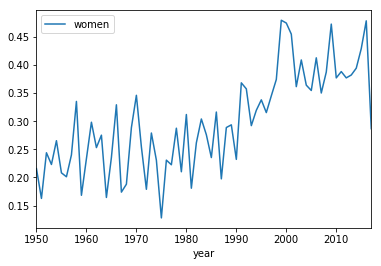

In [108]:
def split_by_gender(processed_ls):
    male = []
    female = []
    for row in processed_ls:
        gender = class_gender(row["genders"])
        if gender == "Female":
            female.append(row)
        if gender == "Male":
            male.append(row)
    return (female,male)

def percent_women_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        new_row = {}
        classified = []
        index = group[0]
        g = grouped.get_group(index)
        for authors in g["genders"]:
            classified.append(class_gender(authors))
        new_row["women"] = percent_women(classified)
        new_row[group_val] = index
        target.append(new_row)
    return target

def class_gender(gender_ls):
    if len(gender_ls) == 1:
        return gender_ls[0]['gender']
    else:
        fem = 0
        male = 0
        for x in gender_ls:
            if x['gender'] == 'Female': ## THIS TREATS MIXED GENDER TEAMS AS FEMALE
                fem = fem+1
                male = male+1
            else:
                if x['gender'] == 'Male':
                    male = male+1
        if fem+male == 0:
            return 'NA'
        ratio = float(fem)/float(fem+male)
        if ratio == 1:
            return 'Female'
        if ratio == 0:
            return 'Male'
        return 'Both'

def percent_women(class_ls):
    i = 0
    for x in class_ls:
        if x == "Female":
            i = i+1
    return float(i)/float(len(class_ls))
            
            
#for x in grouped:
#    index = x[0]
#    group = grouped.get_group(index)
#    print str(index) + str(num_titles(group))

tall_df = pandas.DataFrame(percent_women_binned(processed,"year")).set_index("year")
fig = tall_df.plot().get_figure()
#fig.savefig("women_average_week2.png")

#fig.savefig("women2")


        Female      Male
year                    
1950  0.267606  0.732394
1951  0.250000  0.750000
1952  0.302632  0.697368
1953  0.234375  0.765625
1954  0.261538  0.738462
1955  0.260870  0.739130
1956  0.267606  0.732394
1957  0.277778  0.722222
1958  0.277778  0.722222
1959  0.205882  0.794118
1960  0.253521  0.746479
1961  0.322581  0.677419
1962  0.229508  0.770492
1963  0.300000  0.700000
1964  0.200000  0.800000
1965  0.258065  0.741935
1966  0.352941  0.647059
1967  0.176471  0.823529
1968  0.193548  0.806452
1969  0.333333  0.666667
1970  0.361111  0.638889
1971  0.250000  0.750000
1972  0.210526  0.789474
1973  0.307692  0.692308
1974  0.214286  0.785714
1975  0.147059  0.852941
1976  0.225000  0.775000
1977  0.297872  0.702128
1978  0.279070  0.720930
1979  0.254545  0.745455
...        ...       ...
1988  0.238806  0.761194
1989  0.289157  0.710843
1990  0.280488  0.719512
1991  0.372093  0.627907
1992  0.428571  0.571429
1993  0.313953  0.686047
1994  0.397727  0.602273


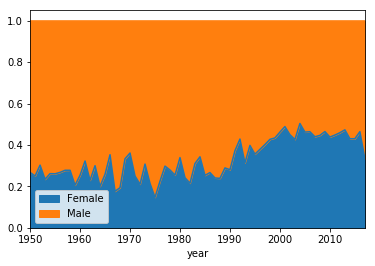

In [182]:
def unique_titles(df_ls):
    ta = set()
    ls = df_ls["title"]
    for x in ls:
        ta.add(x)
    return ta

def num_titles(ls):
    return len(unique_titles(ls))

def count_women_unweighted(ls,group_val):
    new_df = pandas.DataFrame(ls)
    new_df["genders"] = new_df["genders"].apply(class_gender)
    grouped =  new_df.groupby([group_val,"genders"]).apply(num_titles)
    temp = {}
    for index in grouped.index.values:
        year = index[0]
        if year in temp:
            row = temp[year]
        else:
            row = {}
        gender = index[1]
        row[gender] = grouped[index]
        temp[year] = row
    target = []
    for key in temp:
        new_row = {}
        new_row["year"] = key
        menn = temp[key]["Male"]
        womenn = temp[key]["Female"]
        new_row["Male"] = float(menn)/float(menn+womenn) # SCALING
        new_row["Female"] = float(womenn)/float(menn+womenn) # SCALING
        target.append(new_row)
    return target

df = pandas.DataFrame(count_women_unweighted(processed,"year"))
#df = df[df["year"]>2000]
df = df.set_index("year")

ax = df.plot.area()
print df
womens_fig = ax.get_figure()
#womens_fig.savefig("womens_fig_scaled2.png")

{'owi': '104466836', 'title': 'THE SILVER CHALICE', 'authors': ['Thomas B. Costain'], 'fast_subjects': set(['Historical fiction', 'Jesus Christ', 'Christian fiction', 'History of Biblical events', 'Grail', 'Bible.--New Testament', 'Last Supper']), 'year_pub': '1926', 'year': 1953, 'date': datetime.datetime(1953, 4, 19, 0, 0), 'genders': [{'gender': 'Male', 'viaf': '97749233', 'name': 'Thomas B. Costain'}], 'month': 4}
{'owi': '3377313915', 'title': 'THE TENTH INSIGHT', 'authors': ['James Redfield'], 'fast_subjects': set(['Manuscripts, Aramaic', 'Prophecy', 'Adventure stories', 'Tenth insight (Redfield, James)', 'Millennialism in literature', 'Travel', 'Manuscripts--Collectors and collecting', 'Self-realization', 'Parables', 'Spiritual life in literature', 'Peru', 'Millennialism', 'Self-actualization (Psychology)', 'American fiction', 'Redfield, James', 'Spiritual life']), 'year_pub': '1996', 'year': 1996, 'date': datetime.datetime(1996, 5, 19, 0, 0), 'genders': [{'gender': 'Male', 'via

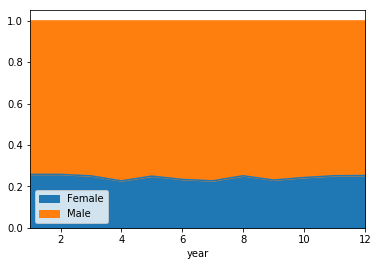

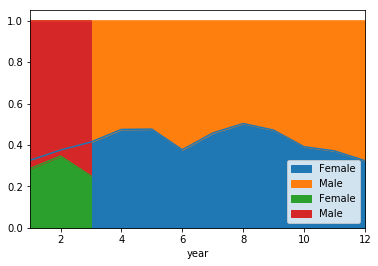

In [97]:


def make_month_col(ls,comp_str,subset_val):
    new_ls = []
    for x in processed:
        year = int(x["year"])
        if comp_str == "<":
            comp = (year < subset_val)
        if comp_str == ">":
            comp = (year > subset_val)
        if comp_str == "=":
            comp = (year == subset_val)
        if comp:
            y = dict(x)
            y["month"] = x["date"].month
            new_ls.append(y)
    return new_ls

new_p = make_month_col(processed,"<",1990)
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
fig = df.plot.area().get_figure()
fig.savefig("month_avg_before1990.png")

#####

new_p = make_month_col(processed,">",1990)
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
fig2 = df.plot.area()#.get_figure()
#fig2.savefig("month_avg_after1990.png")

new_p = make_month_col(processed,"=",2017)
    
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
df.plot.area(ax = fig2)
fig3 = fig2.get_figure()
fig3.savefig("month_2017_comp.png")

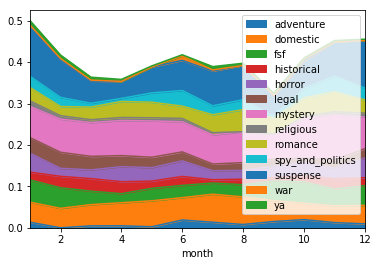

In [105]:
with_month = make_month_col(processed,">",2000) ## all of them

per_df = pandas.DataFrame(percent_genres_binned(with_month,"month")).set_index("month")
fig = per_df.plot.area().get_figure()

In [261]:
def new_class_genre(subject_ls):
    for sub in subject_ls:
        if genre_candidate(sub):
            for genre in genre_dict:
                if is_genre(sub,genre):
                    return genre
    if len(subject_ls)>0:
        return "no genre"
    else:
        return "needs label"

df = pandas.DataFrame(processed)
df = df.drop_duplicates(["title","year"])
df["genre"] = df["fast_subjects"].apply(new_class_genre)
df["gender"] = df["genders"].apply(class_gender)
df.to_csv("the_processed_data.csv",sep='\t')

429


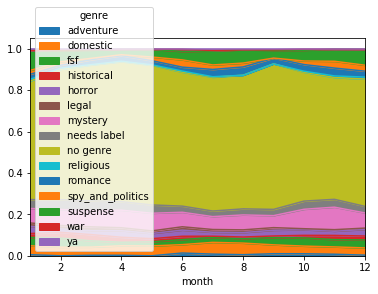

In [273]:
with_month = make_month_col(processed,">",2000) ## all of them
month_df = pandas.DataFrame(with_month)
month_df = month_df.drop_duplicates(["title","month"])
month_df["genre"] = month_df["fast_subjects"].apply(new_class_genre)
month_df["gender"] = month_df["genders"].apply(class_gender)

mg_df = pandas.DataFrame({'count' : month_df.groupby( ["month", "genre"] ).size()}).reset_index()
#print mg_df

df3 = pandas.DataFrame({'sum' : month_df.groupby("month").size()})
#print df3
print df3.loc[3]["sum"]

def count_to_percent(value,group):
    s = df3.loc[group]["sum"]
    return float(value)/float(s)

### USEFUL LINE -- CONVERTS TO PERCENT!
mg_df["percent"] = mg_df.apply(lambda x: count_to_percent(x['count'], x['month']), axis=1)
mg_df = mg_df.pivot(index='month', columns='genre', values='percent')

#df_year_genre = df_year_genre.pivot(index='year', columns='genre', values='count')
figure = mg_df.plot(kind = 'area')


215


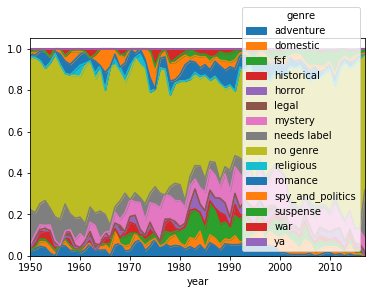

In [275]:

yg_df = pandas.DataFrame({'count' : df.groupby( ["year", "genre"] ).size()}).reset_index()

df3 = pandas.DataFrame({'sum' : df.groupby("year").size()}).reset_index()
df3 = df3.set_index("year")
print df3.loc[2013]["sum"]

### USEFUL LINE -- CONVERTS TO PERCENT!
#yg_df["percent"] = yg_df.apply(lambda x: count_to_percent(x['count'], x['year']), axis=1)

### TOGGLE THESE
### PERCENT:

#yg_df = yg_df.pivot(index='year', columns='genre', values='percent')

### COUNTS:

yg_df = yg_df.pivot(index='year', columns='genre', values='count')

figure = yg_df.plot(kind = 'area')
#g = df.groupby(["year"])
#df_grouped = pandas.DataFrame({'count': g["genre"].value_counts()})#.plot()
#df_grouped

In [238]:
print df_to_json(df2)

<type 'dict'>
[{'values': [[1041408000, 11.0], [852105600, 14.0], [568022400, 4.0], [599644800, 12.0], [504950400, 8.0], [536486400, 9.0], [441792000, 6.0], [473414400, 7.0], [-63129600, 1.0], [-31507200, 4.0], [315561600, 8.0], [347184000, 5.0], [-189360000, 1.0], [-157737600, None], [-126201600, 1.0], [-94665600, 2.0], [-315590400, 5.0], [-283968000, 1.0], [-252432000, 3.0], [-220896000, 3.0], [820483200, 14.0], [1388563200, 16.0], [1483257600, 3.0], [1451635200, 12.0], [1293868800, 23.0], [1262332800, 14.0], [1357027200, 17.0], [1325404800, 12.0], [1420099200, 13.0], [1104566400, 8.0], [-473356800, 1.0], [-504892800, 2.0], [-410198400, None], [-441820800, None], [-599587200, 2.0], [-631123200, None], [-536428800, 1.0], [-568051200, 2.0], [378720000, 6.0], [-347126400, 2.0], [-378662400, 1.0], [410256000, 3.0], [662716800, 12.0], [631180800, 12.0], [725875200, 10.0], [694252800, 15.0], [788947200, 8.0], [757411200, 15.0], [284025600, 6.0], [252489600, 5.0], [220953600, 6.0], [1893312

In [237]:
import time

def time_from_y(y):
    dt = datetime(year=int(y), month=1, day=1)
    tt = time.mktime(dt.timetuple())
    return int(tt)

def df_to_json(dataframe):
    j = dataframe.to_json()
    j = json.loads(j)
    print type(j)
    k = []
    for x in j:
        target = {}
        target["key"] = x
        v = []
        for y in j[x]:
            timey = time_from_y(y)
            value = j[x][y]
            point = [timey,value]
            v.append(point)
        target["values"] = v
        k.append(target)
    return k

In [136]:
per_df

,adventure,domestic,fsf,historical,horror,legal,mystery,religious,romance,spy_and_politics,suspense,war,ya
month,,,,,,,,,,,,,
1,0.013441,0.048387,0.053763,0.018817,0.045699,0.037634,0.075269,0.013441,0.032258,0.026882,0.123656,0.000000,0.010753
2,0.000000,0.046961,0.049724,0.027624,0.019337,0.038674,0.080110,0.008287,0.022099,0.022099,0.091160,0.002762,0.008287
3,0.004662,0.051282,0.032634,0.030303,0.020979,0.032634,0.081585,0.006993,0.030303,0.009324,0.053613,0.002331,0.006993
4,0.004843,0.055690,0.021792,0.029056,0.036320,0.026634,0.084746,0.007264,0.038741,0.007264,0.041162,0.000000,0.004843
5,0.002506,0.062657,0.030075,0.017544,0.032581,0.025063,0.087719,0.007519,0.037594,0.022556,0.062657,0.000000,0.002506
6,0.018868,0.053908,0.029650,0.021563,0.037736,0.021563,0.072776,0.008086,0.029650,0.037736,0.072776,0.010782,0.002695
7,0.013514,0.067568,0.027027,0.008108,0.021622,0.016216,0.070270,0.005405,0.043243,0.021622,0.083784,0.002703,0.008108
8,0.008000,0.066667,0.029333,0.013333,0.021333,0.018667,0.074667,0.000000,0.053333,0.024000,0.082667,0.000000,0.005333
9,0.015113,0.050378,0.047859,0.007557,0.027708,0.017632,0.060453,0.000000,0.037783,0.005038,0.047859,0.002519,0.005038
